<a href="https://colab.research.google.com/github/ahmedyasser7/DEPI_GP/blob/main/CASUALTY_SEVERITY_PREDICTIVE_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CASUALTY SEVERITY PREDICTIVE MODEL**

# Uploading The Dataset

In [1]:
from google.colab import files
uploaded = files.upload()

Saving casualties cleaned data.csv to casualties cleaned data.csv


# Importing Libraries

In [1]:
# Importing the necessary Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import faiss

In [42]:
pip install faiss-Gpu


#Load the Dataset

In [26]:
# Load the 'casualties cleaned data.csv' dataset
df = pd.read_csv('casualties cleaned data.csv')
df

,Accident_Index,Casualty_Reference,Sex_of_Casualty,Age_of_Casualty,Casualty_Severity,Car_Passenger,Bus_or_Coach_Passenger,Casualty_Type
0,200901BS70001,1,1,77,2,0,0,2
1,200901BS70002,1,1,40,3,0,0,19
2,200901BS70002,2,1,38,3,0,0,11
3,200901BS70002,3,2,76,2,0,4,11
4,200901BS70002,4,1,42,2,0,4,11
...,...,...,...,...,...,...,...,...
1185978,2014984137714,1,2,16,3,2,0,9
1185979,2014984138414,1,1,27,3,0,0,9
1185980,2014984138414,2,1,44,2,0,0,19
1185981,2014984139614,2,1,61,3,0,4,11


# Exploring & Preprocessing the Data

In [27]:
df.head()

,Accident_Index,Casualty_Reference,Sex_of_Casualty,Age_of_Casualty,Casualty_Severity,Car_Passenger,Bus_or_Coach_Passenger,Casualty_Type
0,200901BS70001,1,1,77,2,0,0,2
1,200901BS70002,1,1,40,3,0,0,19
2,200901BS70002,2,1,38,3,0,0,11
3,200901BS70002,3,2,76,2,0,4,11
4,200901BS70002,4,1,42,2,0,4,11


In [28]:
# Get information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185983 entries, 0 to 1185982
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   Accident_Index          1185983 non-null  object
 1   Casualty_Reference      1185983 non-null  int64 
 2   Sex_of_Casualty         1185983 non-null  int64 
 3   Age_of_Casualty         1185983 non-null  int64 
 4   Casualty_Severity       1185983 non-null  int64 
 5   Car_Passenger           1185983 non-null  int64 
 6   Bus_or_Coach_Passenger  1185983 non-null  int64 
 7   Casualty_Type           1185983 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 72.4+ MB


In [29]:
df.describe()

,Casualty_Reference,Sex_of_Casualty,Age_of_Casualty,Casualty_Severity,Car_Passenger,Bus_or_Coach_Passenger,Casualty_Type
count,1.185983e+06,1.185983e+06,1.185983e+06,1.185983e+06,1.185983e+06,1.185983e+06,1.185983e+06
mean,1.431425e+00,1.415368e+00,3.576307e+01,2.866305e+00,2.729634e-01,8.525839e-02,7.387409e+00
std,1.608286e+00,4.927855e-01,1.850742e+01,3.670351e-01,5.857770e-01,5.507572e-01,7.306746e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,2.100000e+01,3.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
50%,1.000000e+00,1.000000e+00,3.200000e+01,3.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00
75%,2.000000e+00,2.000000e+00,4.800000e+01,3.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00
max,8.520000e+02,2.000000e+00,1.030000e+02,3.000000e+00,2.000000e+00,4.000000e+00,9.800000e+01


In [30]:
df.shape

(1185983, 8)

In [31]:
# Check for missing values
df.isnull().sum()

,0
Accident_Index,0
Casualty_Reference,0
Sex_of_Casualty,0
Age_of_Casualty,0
Casualty_Severity,0
Car_Passenger,0
Bus_or_Coach_Passenger,0
Casualty_Type,0


In [32]:
# Check for duplicate values
df.duplicated().sum()

0

# Model Selection & Training

## Define Features and Target Variable

In [33]:
# Define feature columns and target variable
feature_columns = ['Sex_of_Casualty', 'Age_of_Casualty',
                   'Car_Passenger', 'Bus_or_Coach_Passenger', 'Casualty_Type']
X = df[feature_columns]
y = df['Casualty_Severity']


## Check Class Distribution

In [34]:
# Check initial class distribution
print(f"Initial class distribution: {Counter(y)}")


Initial class distribution: Counter({3: 1038627, 2: 136152, 1: 11204})


## Split the Dataset

In [35]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check class distribution after the split
print(f"Class distribution in training set: {Counter(y_train)}")
print(f"Class distribution in test set: {Counter(y_test)}")


Class distribution in training set: Counter({3: 830901, 2: 108922, 1: 8963})
Class distribution in test set: Counter({3: 207726, 2: 27230, 1: 2241})


## Handle Class Imbalance

In [36]:
# Handle class imbalance using ADASYN on the training set
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_balanced, y_balanced = adasyn.fit_resample(X_train, y_train)

# Display class distribution after ADASYN on training data
print(f"Class distribution after ADASYN on training set: {Counter(y_balanced)}")

# Handle class imbalance using ADASYN on the test set (for demonstration purposes)
X_test_balanced, y_test_balanced = adasyn.fit_resample(X_test, y_test)

# Display class distribution after ADASYN on test data
print(f"Class distribution after ADASYN on test set: {Counter(y_test_balanced)}")



Class distribution after ADASYN on training set: Counter({3: 830901, 1: 828271, 2: 108922})
Class distribution after ADASYN on test set: Counter({3: 207726, 1: 207498, 2: 27230})


#Scale Features and Apply PCA

In [37]:
# Set n_components to a valid value (<= number of features in your dataset)
n_components = 5  # Adjust as necessary

# Scale features and apply PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

#Create a Faiss Index for Efficient KNN

In [38]:
# Create a Faiss index
d = X_pca.shape[1]  # Number of features after PCA

# Faiss IndexFlatL2 expects float32 type data
X_pca_float32 = X_pca.astype('float32')  # Cast to float32

# Create an index with L2 distance metric
index = faiss.IndexFlatL2(d)

# Add the training data (in float32 format) to the index
index.add(X_pca_float32)



#Define Function for Faiss Prediction

In [39]:
# Function to predict using Faiss
def faiss_predict(X_test):
    # Scale and apply PCA to the test set
    X_test_scaled = scaler.transform(X_test)
    X_test_pca = pca.transform(X_test_scaled)

    # Ensure that X_test_pca is in the float32 format
    X_test_pca = np.array(X_test_pca, dtype=np.float32)

    # Perform nearest neighbor search
    k = 3  # Number of neighbors
    distances, indices = index.search(X_test_pca, k)

    # Initialize predictions array
    y_pred = np.zeros(X_test.shape[0], dtype=int)
    for i in range(X_test.shape[0]):
        # Get the labels of the nearest neighbors
        neighbor_labels = y_balanced[indices[i]]
        # Use majority vote for classification
        y_pred[i] = np.bincount(neighbor_labels).argmax()

    return y_pred



#Make Predictions Using Faiss

In [40]:
# Make predictions on the test set using Faiss
y_pred_numeric = faiss_predict(X_test)

#Map Predictions to Labels

In [41]:
# Define the mapping from numeric predictions to string labels
label_mapping = {1: 'Fatal', 2: 'Serious', 3: 'Slight'}

# Map the numeric predictions to string labels
#y_pred_labels = [label_mapping[pred] for pred in y_pred_numeric]


#Evaluate the Model

In [42]:
# Calculate accuracy using the numeric predictions
accuracy = accuracy_score(y_test, y_pred_numeric)

# Generate confusion matrix and classification report using numeric predictions
conf_matrix = confusion_matrix(y_test, y_pred_numeric)
class_report = classification_report(y_test, y_pred_numeric)


#Store Evaluation Results

In [43]:
# Store evaluation results
evaluation_results = {
    'KNN (with Faiss)': {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }
}

# Display evaluation results for the KNN model
for model_name, results in evaluation_results.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {results['accuracy']:.4f}")



Model: KNN (with Faiss)
Accuracy: 0.8392


#Display Classification Report

In [44]:
# Print the classification report
print(f"KNN Classification Report:\n{class_report}")


KNN Classification Report:
              precision    recall  f1-score   support

           1       0.03      0.03      0.03      2241
           2       0.20      0.08      0.12     27230
           3       0.88      0.95      0.91    207726

    accuracy                           0.84    237197
   macro avg       0.37      0.36      0.35    237197
weighted avg       0.80      0.84      0.81    237197



#Plot Confusion Matrix

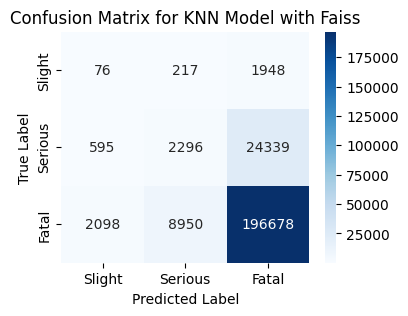

In [45]:
# Draw the confusion matrix using seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Slight', 'Serious', 'Fatal'],
            yticklabels=['Slight', 'Serious', 'Fatal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN Model with Faiss')
plt.show()


# Save Model

In [46]:
import pickle
from google.colab import files

# Store all models and data in a dictionary
model_data = {
    'scaler': scaler,
    'pca': pca,
    'faiss_index': index,
    'label_mapping': label_mapping,
    'accuracy': accuracy,
    'confusion_matrix': conf_matrix,
    'classification_report': class_report,
   # 'y_balanced': y_balanced  # Add this line
}

# Save the model data dictionary to a single file using pickle
with open('Causality_data.pkl', 'wb') as file:
    pickle.dump(model_data, file)

# Download the saved model data file
files.download('Causality_data.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Load Model & Predict


In [47]:
import numpy as np
import pandas as pd
import pickle
import faiss  # Faiss for efficient KNN
from collections import Counter

# Load the saved model data
with open('Causality_data.pkl', 'rb') as file:
    model_data = pickle.load(file)

# Extract necessary components from the loaded model data
scaler = model_data['scaler']
pca = model_data['pca']
index = model_data['faiss_index']
label_mapping = model_data['label_mapping']

# Function to predict using Faiss
def faiss_predict(X_test):
    # Scale and apply PCA to the test set
    X_test_scaled = scaler.transform(X_test)
    X_test_pca = pca.transform(X_test_scaled)

    # Ensure that X_test_pca is in the float32 format
    X_test_pca = np.array(X_test_pca, dtype=np.float32)

    # Perform nearest neighbor search
    k = 3  # Number of neighbors
    distances, indices = index.search(X_test_pca, k)

    # Initialize predictions array
    y_pred = np.zeros(X_test.shape[0], dtype=int)
    for i in range(X_test.shape[0]):
        # Get the labels of the nearest neighbors from the original labels
        neighbor_labels = y[indices[i]]
        # Use majority vote for classification
        y_pred[i] = np.bincount(neighbor_labels).argmax()

    return y_pred

# Function to get user input for features
def get_user_input():
    sex_of_casualty = int(input("Enter Sex of Casualty (0 for Female, 1 for Male): "))
    age_of_casualty = int(input("Enter Age of Casualty: "))
    car_passenger = int(input("Enter if the casualty was a Car Passenger (0 for No, 1 for Yes): "))
    bus_or_coach_passenger = int(input("Enter if the casualty was a Bus/Coach Passenger (0 for No, 1 for Yes): "))
    casualty_type = int(input("Enter Casualty Type (1 for Driver, 2 for Passenger, 3 for Pedestrian): "))

    return pd.DataFrame({
        'Sex_of_Casualty': [sex_of_casualty],
        'Age_of_Casualty': [age_of_casualty],
        'Car_Passenger': [car_passenger],
        'Bus_or_Coach_Passenger': [bus_or_coach_passenger],
        'Casualty_Type': [casualty_type]
    })

# Get user input
X_test_user = get_user_input()

# Make predictions on the user input using Faiss
y_pred_numeric = faiss_predict(X_test_user)

# Map predictions back to original labels
y_pred_labels = [label_mapping[label] for label in y_pred_numeric]

# Print predictions
for pred in y_pred_labels:
    print(f"Predicted Casualty Severity: {pred}")


Enter Sex of Casualty (0 for Female, 1 for Male): 1
Enter Age of Casualty: 55
Enter if the casualty was a Car Passenger (0 for No, 1 for Yes): 0
Enter if the casualty was a Bus/Coach Passenger (0 for No, 1 for Yes): 0
Enter Casualty Type (1 for Driver, 2 for Passenger, 3 for Pedestrian): 2
Predicted Casualty Severity: Slight
